### Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle 
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn import tree
from matplotlib import pyplot
import joblib
from xgboost import XGBClassifier
from scipy import stats
from scipy.signal import find_peaks

%matplotlib inline

In [2]:
path = r"Overall_DA_Dataset_with_APR.csv"
df = pd.read_csv(path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78711 entries, 0 to 78710
Columns: 105 entries, x_mean to Labels
dtypes: float64(86), int64(18), object(1)
memory usage: 63.1+ MB


In [4]:
df.Labels.value_counts()

Asphalt_Ride        51189
Stop                14193
Cobblestone_Ride     9508
Asphalt_Manhole      2824
Asphalt_Kurb          621
Asphalt_Bump          376
Name: Labels, dtype: int64

In [5]:
X = df.drop('Labels', axis=1)
y = df["Labels"]

In [6]:
# to split the available data to train and test
def split_train_test(df, y):
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test 


# to normalize the columns using standard scaler
class standardscaler(TransformerMixin):
    def __init__(self):
        self.ss=None
        self.mean_=None
        self.scale_=None
    def fit(self, X, y=None):
        self.ss=StandardScaler()
        self.ss.fit(X)
        self.mean_ = pd.Series(self.ss.mean_, index=X.columns)
        self.scale_ = pd.Series(self.ss.scale_, index=X.columns)
        return self
    def transform(self, X):
        x=self.ss.transform(X)
        numeric=pd.DataFrame(x, columns=X.columns)
        return numeric

# to normalize the columns using standard scaler
class max_minscaler(TransformerMixin):
    def __init__(self):
        self.mms=None

    def fit(self, X, y=None):
        self.mms = MinMaxScaler()
        self.mms.fit(X)
        return self
    def transform(self, X):
        x=self.mms.transform(X)
        numeric=pd.DataFrame(x, columns=X.columns)
        return numeric

In [7]:
X_train, X_test, y_train, y_test = split_train_test(X, y)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62968 entries, 58272 to 68268
Columns: 104 entries, x_mean to Speed_(km/hr)
dtypes: float64(86), int64(18)
memory usage: 50.4 MB


In [9]:
'''
mms = max_minscaler()
pipeline = make_pipeline(mms)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
'''

ss = standardscaler()
pipeline = make_pipeline(ss)
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [10]:
ss.mean_.to_pickle(r"C:\Users\arockias\Desktop\SmartRadL\SmartRadL\Programs\Machine Learning\Models\ss_mean.pkl")
ss.scale_.to_pickle(r"C:\Users\arockias\Desktop\SmartRadL\SmartRadL\Programs\Machine Learning\Models\ss_scale.pkl")  

### Machine learning Algorithms

In [11]:
class train_machine_learning():
    def __init__(self, X_train, X_test, y_train, y_test, save_path):
        self.X_train = X_train       
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.save_path = save_path
        
    def logistic_regression(self, C=100, class_weight = "balanced", multi_class= "ovr"):
        self.lr = LogisticRegression(C=C, class_weight=class_weight, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100,
             multi_class= multi_class, n_jobs=None, penalty='l2', random_state=None, solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
        
        self.lr.fit(self.X_train, self.y_train)
        filename = self.save_path+"\\"+'lr_model.pkl'
        joblib.dump(self.lr, open(filename, 'wb'))
        
        lr_train_score = self.lr.score(self.X_train, self.y_train)
        lr_test_score = self.lr.score(self.X_test, self.y_test)
        lr_pre = self.lr.predict(self.X_test)
        lr_f1_s = f1_score(self.y_test, lr_pre, average ="weighted")
        lr_classification_report = classification_report(self.y_test, lr_pre)
        
        #return lr_pre
        return lr_train_score, lr_test_score, lr_f1_s, lr_classification_report
     
    def support_vector_machine(self, C=20, class_weight = "balanced", decision_function_shape = "ovo", kernel = 'rbf'):
        self.svc = SVC(C=C, break_ties=False, cache_size=200, class_weight= class_weight, decision_function_shape= decision_function_shape,  gamma='scale', kernel= kernel,max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
        
        self.svc.fit(self.X_train, self.y_train)
        filename = self.save_path+"\\"+'svc_model.pkl'
        joblib.dump(self.svc, open(filename, 'wb'))
        
        svc_train_score = self.svc.score(self.X_train, self.y_train)
        svc_test_score = self.svc.score(self.X_test, self.y_test)
        svc_pre = self.svc.predict(self.X_test)
        svc_f1_s = f1_score(self.y_test, svc_pre, average ="weighted")
        svc_classification_report = classification_report(self.y_test, svc_pre)
        
        #return svc_pre
        return svc_train_score, svc_test_score, svc_f1_s, svc_classification_report
    
    def decision_tree(self, max_depth = 13, min_samples_leaf = 2, cri = 'gini', class_weight = "balanced"):
        self.dtc = DecisionTreeClassifier(max_depth = max_depth, criterion = cri, min_samples_split=4, min_samples_leaf= min_samples_leaf, class_weight=class_weight)
        
        self.dtc.fit(self.X_train, self.y_train)
        filename = self.save_path+"\\"+'dtc_model.pkl'
        joblib.dump(self.dtc, open(filename, 'wb'))
        
        dtc_train_score = self.dtc.score(self.X_train, self.y_train)
        dtc_test_score = self.dtc.score(self.X_test, self.y_test)
        dtc_pre = self.dtc.predict(self.X_test)
        dtc_f1_s = f1_score(self.y_test, dtc_pre, average ="weighted")
        dtc_classification_report = classification_report(self.y_test, dtc_pre)
   
        return dtc_train_score, dtc_test_score, dtc_f1_s, self.dtc.feature_importances_,  dtc_classification_report

    def XGboost(self, objective="multi:softprob", random_state=42, use_label_encoder=False):
        self.xgb = XGBClassifier(objective=objective, random_state= random_state, use_label_encoder= use_label_encoder)
        
        self.xgb.fit(self.X_train, y_train)
        filename = self.save_path+"\\"+'xgb_model.pkl'
        joblib.dump(self.xgb, open(filename, 'wb'))
        
        xgb_train_score = self.xgb.score(self.X_train, y_train)
        xgb_test_score = self.xgb.score(self.X_test, y_test)
        xgb_pre = self.xgb.predict(self.X_test)
        xgb_f1_s = f1_score(y_test, xgb_pre, average ="weighted")
   
        return xgb_train_score, xgb_test_score, xgb_f1_s, self.xgb.feature_importances_

In [12]:
ml = train_machine_learning(X_train, X_test, y_train, y_test, save_path = r"C:\Users\arockias\Desktop\SmartRadL\SmartRadL\Programs\Machine Learning\Models")

##### logistic Regression

In [13]:
lr_train_score, lr_test_score, lr_f1_score, lr_classification_report = ml.logistic_regression(C=100, class_weight = "balanced", multi_class= "ovr")

C:\Users\arockias\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\arockias\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\arockias\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\arockias\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [14]:
lr_train_score, lr_test_score, lr_f1_score

(0.8061585859708745, 0.8086768722606873, 0.8215163456424912)

In [15]:
print(lr_classification_report)

                  precision    recall  f1-score   support

    Asphalt_Bump       0.19      0.66      0.29        90
    Asphalt_Kurb       0.12      0.24      0.16       102
 Asphalt_Manhole       0.38      0.53      0.44       547
    Asphalt_Ride       0.93      0.82      0.87     10181
Cobblestone_Ride       0.51      0.63      0.56      2003
            Stop       0.91      0.99      0.95      2820

        accuracy                           0.81     15743
       macro avg       0.51      0.64      0.55     15743
    weighted avg       0.84      0.81      0.82     15743



##### Support Vector Machine

In [13]:
svc_train_score, svc_test_score, svc_f1_score, svc_classification_report = ml.support_vector_machine(C=2, class_weight = "balanced", decision_function_shape = "ovo", kernel = 'rbf')

In [14]:
svc_train_score, svc_test_score, svc_f1_score

(0.8638355990344302, 0.8221431747443309, 0.8358171448041525)

In [15]:
print(svc_classification_report)

                  precision    recall  f1-score   support

    Asphalt_Bump       0.31      0.19      0.24        78
    Asphalt_Kurb       0.26      0.47      0.33       108
 Asphalt_Manhole       0.30      0.61      0.40       541
    Asphalt_Ride       0.96      0.80      0.88     10217
Cobblestone_Ride       0.57      0.78      0.66      1924
            Stop       0.88      0.99      0.93      2875

        accuracy                           0.82     15743
       macro avg       0.55      0.64      0.57     15743
    weighted avg       0.87      0.82      0.84     15743



##### Decision Tree Classifier

In [19]:
dtc_train_score, dtc_test_score, dtc_f1_score, dtc_importance, dtc_classification_report = ml.decision_tree(max_depth = 13, cri = 'gini', min_samples_leaf = 2, class_weight = "balanced")

In [20]:
dtc_train_score, dtc_test_score, dtc_f1_score 

(0.9158633613365307, 0.8916343771835101, 0.9074562782850768)

In [21]:
print(dtc_classification_report)

                  precision    recall  f1-score   support

    Asphalt_Bump       0.52      0.66      0.58        90
    Asphalt_Kurb       0.30      0.60      0.40       102
 Asphalt_Manhole       0.28      0.73      0.41       547
    Asphalt_Ride       0.97      0.88      0.92     10181
Cobblestone_Ride       0.89      0.91      0.90      2003
            Stop       0.99      0.99      0.99      2820

        accuracy                           0.89     15743
       macro avg       0.66      0.79      0.70     15743
    weighted avg       0.93      0.89      0.91     15743



x_mean Feature No: 0, Score: 0.00212
x_std Feature No: 1, Score: 0.00000
x_aad Feature No: 2, Score: 0.00016
x_min Feature No: 3, Score: 0.00440
x_max Feature No: 4, Score: 0.00355
x_maxmin_diff Feature No: 5, Score: 0.00057
x_median Feature No: 6, Score: 0.00163
x_mad Feature No: 7, Score: 0.00000
x_IQR Feature No: 8, Score: 0.00115
x_neg_count Feature No: 9, Score: 0.00178
x_pos_count Feature No: 10, Score: 0.00012
x_above_mean Feature No: 11, Score: 0.00006
x_peak_count Feature No: 12, Score: 0.00022
x_skewness Feature No: 13, Score: 0.00005
x_kurtosis Feature No: 14, Score: 0.00008
x_energy Feature No: 15, Score: 0.01024
y_mean Feature No: 16, Score: 0.00476
y_std Feature No: 17, Score: 0.00201
y_aad Feature No: 18, Score: 0.00049
y_min Feature No: 19, Score: 0.00575
y_max Feature No: 20, Score: 0.00371
y_maxmin_diff Feature No: 21, Score: 0.00163
y_median Feature No: 22, Score: 0.00262
y_mad Feature No: 23, Score: 0.00011
y_IQR Feature No: 24, Score: 0.00075
y_neg_count Feature No

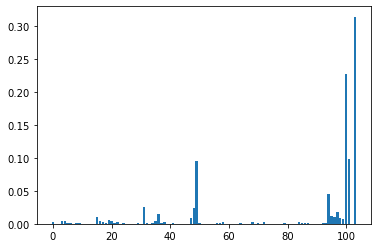

In [22]:
for i,v in enumerate(dtc_importance):
    print(X.columns[i] + ' Feature No: %i, Score: %.5f' % (i, v))
    
# plot feature importance
pyplot.bar([x for x in range(len(dtc_importance))], dtc_importance)
pyplot.show()